**To address the imbalance nature between pixels of classes, we should focus on augmenting the minority classes, whose total count of pixels is low in number.**

**Idea:** We would want to augment $m$ more samples from existing set $I$ of $n$ X-ray images; and the minority classes should be prioritized. Therefore, we view those $n$ images as a **sampling distribution**, there exists 2 objectives:
1. Images containing **more** minority classes have the **higher** probability.
2. Images containing **more** pixels of minority classes have the **higher** probability.

*In another sense*: the **rarer** an image is (rare class pixels constituting the whole image), the **higher** probability such image will be sampled for augmentation. This is much like TF-IDF used in document retrieval, if we see each image as document, each pixel as a term and each pixel class as a word in vocabulary.

One way to measure the rareness of pixel classes constituting an image $i$ is to compute their entropy (ie. The less common, the higher the entropy). Entropy's formula has some nice properties: *(1)* Entropy is proportional to rareness (unlike probability, which is inversely proportional); *(2)* Entropy performs summation operation, which does not suffer from numerical error (whereas joint probability relies on product operation that leads to a very small and inaccurate number).

The original entropy formula is as
$$ H(X) = -\sum_{x \in X} p(x)\log p(x) $$
where $\log p(x)$ represents information gained once event $x$ happened, while the $p(x)$ term outside represents the mean operation.

In order to achieve 2 objectives above, the entropy formula applied to an image $i$ is reframed, similar to TF-IDF
$$ H(i) = -\sum_{c \in C} \frac{N_i(c)}{N_i} \log \frac{N(c)}{N} $$
where
- $N_i(c)$ is the number of pixels of class $c$ in image $i$
- $N_i$ is the total number of pixels in image $i$
- $N(c)$ is the total number of pixels of class $c$ in the whole dataset
- $N$ is the total number of pixels in the whole dataset

This way, the formula can satisfy **object 1** with $\log \frac{N(c)}{N}$ term, which represents information gained once class $c$ appears in image $i$; and satisfies **objective 2** with $\frac{N_i(c)}{N_i}$ term that can encode the impact of the amount of pixels of class $c$ within image $i$. The overall entropy of image $i$ is computed by summing all average information gained of each class $c \in C$.

To convert the list of entropy values of each image into a sampling distribution, their entropy values are normalized to ensure their sum being equal to 1.
$$ P(i) = \frac{H(i)}{\sum_{i \in I} H(i)} $$

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torchvision.transforms import v2
from numpy.typing import ArrayLike
from typing import Sequence, Callable, Any

In [4]:
def read_labelmap(path: str):
    mapper = {}
    labels = []
    with open(path, "r") as f:
        txt = f.read().split("\n")[1:-1]
        for i, cls in enumerate(txt):
            c = cls.split(":")
            label = c[0]
            color = tuple(map(int, c[1].split(",")))
            mapper[color] = i
            labels.append(label)
    return mapper, labels

def plot_label_dist(masks: ArrayLike, classes: Sequence[str], mapper: dict, suptilte=""):
    img_contains_class = {label: 0 for label in classes}
    for label, cls_idx in zip(classes, mapper.values()):
        for mask in masks:
            img_contains_class[label] += cls_idx in mask
    img_contains_class = dict(sorted(img_contains_class.items(), key=lambda x: x[1]))

    fig, ax = plt.subplots(2, 1, figsize=(6, 8))
    fig.suptitle(suptilte)

    ax[0].barh(list(img_contains_class.keys()), img_contains_class.values())
    display_bar_num(ax[0])
    ax[0].set_title("Number of images that each class appears in")

    label_proportion = {label: [] for label in classes}

    for (rgb, class_idx), label in zip(mapper.items(), classes):
        label_proportion[label].extend([
            np.count_nonzero(mask == class_idx) / mask.size
            for mask in masks
        ])

    sns.barplot(pd.DataFrame(label_proportion), orient="h", ax=ax[1]).set(
        title="Avg. class proportion in an image",
        xlabel="Percentage"
    )
    sns.despine()

def display_bar_num(ax, predicate: Callable[[Any], Any] = lambda x: x):
    for container in ax.containers:
        ax.bar_label(predicate(container))

In [5]:
mapper, classes = read_labelmap("Annotations/labelmap.txt")

# Read data
with open("Annotations/ImageSets/Segmentation/PERIAPICALS.txt", "r") as f:
    names = f.read().split()
    names.remove("X18420_35")

images = [
    cv2.imread(f"Images/{name}.JPG", flags=cv2.IMREAD_GRAYSCALE)
    for name in tqdm(names, desc="Reading images", leave=True, position=0)
]
masks = [
#     rgb_to_class(cv2.cvtColor(cv2.imread(f"Annotations/SegmentationClass/{name}.png"), cv2.COLOR_BGR2RGB), mapper)
    np.load(f"Masks/{name}.npy")
    for name in tqdm(names, desc="Reading masks", leave=True, position=0)
]

Reading masks: 100%|██████████| 2158/2158 [00:02<00:00, 991.02it/s] 


In [4]:
def create_dist(masks: ArrayLike, classes: Sequence[str], T: float = 1):
    total_px = 0
    px_cls_count = {i: 0 for i, cls in enumerate(classes)}
    for mask in masks:
        total_px += mask.size
        for i, cls in enumerate(classes):
            px_cls_count[i] += np.sum(mask == i)
    idf = np.log(pd.Series(px_cls_count) / total_px + 1e-5)
    
    H_i_list = []
    for mask in masks:
        cls_count = pd.Series(mask.ravel()).value_counts()
        tf = np.array([
            cls_count.get(i, 0) / mask.size
            for i, cls in enumerate(classes)
        ])
        H_i = -np.sum(tf * idf)
        
        H_i_list.append(H_i)
    
    # Normalize, sum(probs) = 1
    H_i_list = np.array(H_i_list)
    # H_i_list = H_i_list / H_i_list.sum()
    exp_list = np.exp(H_i_list / T)
    H_i_list = exp_list / exp_list.sum()
    return H_i_list

In [5]:
sampling_dist = create_dist(masks, classes, T=10)
pd.Series(sampling_dist).describe()

count    2158.000000
mean        0.000463
std         0.000013
min         0.000444
25%         0.000454
50%         0.000459
75%         0.000469
max         0.000543
dtype: float64

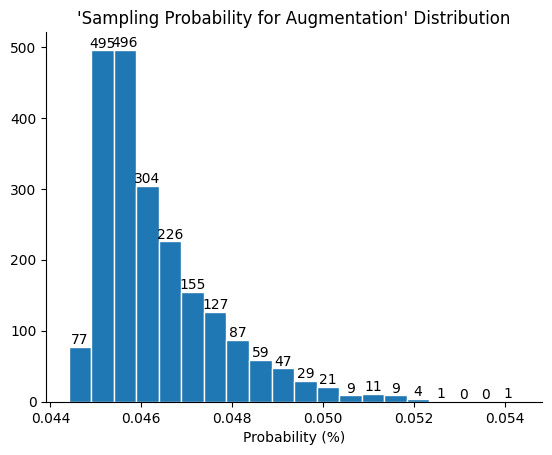

In [6]:
plt.hist(sampling_dist * 100, bins=20, edgecolor="white")
plt.title("'Sampling Probability for Augmentation' Distribution")
display_bar_num(plt.gca())
plt.xlabel("Probability (%)")
sns.despine()

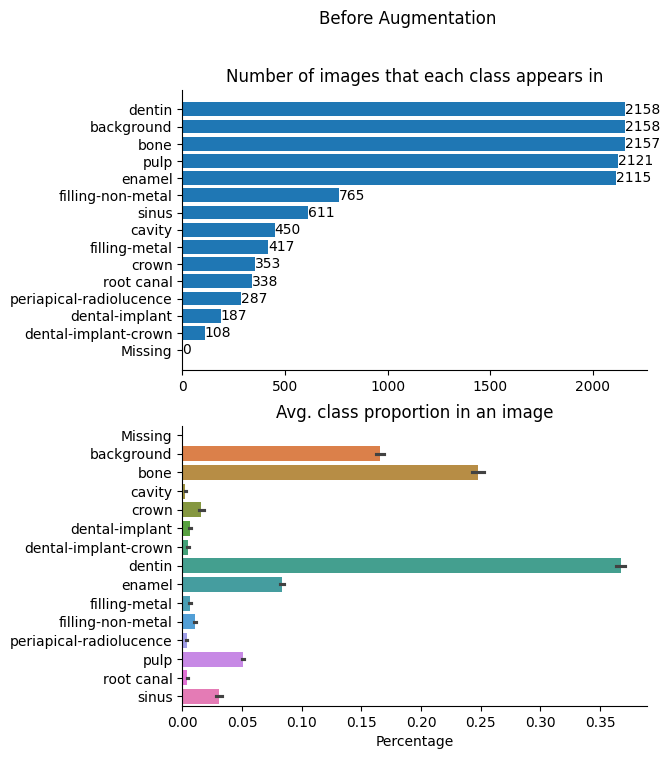

In [7]:
plot_label_dist(masks, classes, mapper, suptilte="Before Augmentation")

In [8]:
n_samples = 10

print("NUMBER OF PIXEL OF EACH CLASS IN SAMPLED IMAGES")
for i in np.random.choice(range(len(masks)), size=n_samples, replace=True, p=sampling_dist):
    print(f"================={i}-th Image=================")
    for cls_i, count in pd.Series(masks[i].ravel()).value_counts().items():
        print(f"\033[1m{classes[cls_i]}:\033[0m {count} px")

NUMBER OF PIXEL OF EACH CLASS IN SAMPLED IMAGES
=================1728-th Image=================
bone: 229633 px
dentin: 179397 px
background: 52734 px
enamel: 43196 px
pulp: 40466 px
filling-non-metal: 10151 px
cavity: 4475 px
=================753-th Image=================
dentin: 229510 px
bone: 97510 px
background: 69677 px
enamel: 67617 px
sinus: 58546 px
pulp: 30283 px
filling-non-metal: 6909 px
=================482-th Image=================
dentin: 245869 px
bone: 134369 px
enamel: 81633 px
background: 64084 px
pulp: 31085 px
=================1058-th Image=================
dentin: 218562 px
bone: 186742 px
background: 51187 px
filling-non-metal: 37738 px
pulp: 35821 px
enamel: 30002 px
=================2119-th Image=================
dentin: 926269 px
bone: 861123 px
background: 481984 px
enamel: 377667 px
pulp: 176597 px
=================302-th Image=================
dentin: 226308 px
bone: 141143 px
background: 105123 px
pulp: 48191 px
enamel: 36275 px
=================2110-th Im

**Augment transformations:**
1. *Random Brightness:* $[0.8, 1]$
2. *Random Contrast:* $[0.8, 1.2]$
3. *Random Rotate:* $[-10^\circ, 10^\circ]$
4. *Random Scale:* $[0.95, 1.05]$
5. *Random Horizontal Flip:* $50\%$
6. *Random Resized Crop:* $[0.7, 1]$
7. *Output Size:* ($660, 844$)

In [31]:
augmenter = v2.Compose([
    # v2.ColorJitter(brightness=(0.8, 1), contrast=0.2),
    v2.RandomAffine(degrees=10, scale=(0.95, 1.05), fill=1),
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop((660, 844), scale=(0.7, 1))
])

def augment_sample(augmenter: v2.Compose, image: ArrayLike, mask: ArrayLike):
    rng_state = torch.get_rng_state()
    i_trans = augmenter(torch.from_numpy(image).reshape(1, *image.shape))
    torch.set_rng_state(rng_state)
    m_trans = augmenter(torch.from_numpy(mask).reshape(1, *mask.shape))
    return i_trans.squeeze(0).numpy(), m_trans.squeeze(0).numpy()

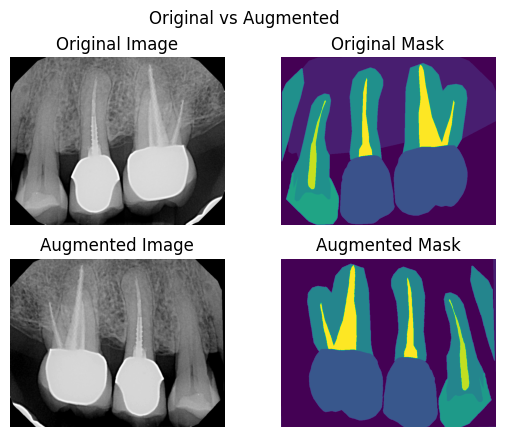

In [32]:
i_trans, m_trans = augment_sample(augmenter, images[0], masks[0])
fig, ax = plt.subplots(2, 2)
fig.suptitle("Original vs Augmented")

ax[0, 0].imshow(images[0], cmap="gray")
ax[0, 1].imshow(masks[0])
ax[1, 0].imshow(i_trans, cmap="gray")
ax[1, 1].imshow(m_trans)

ax[0, 0].set_title("Original Image")
ax[0, 1].set_title("Original Mask")
ax[1, 0].set_title("Augmented Image")
ax[1, 1].set_title("Augmented Mask")
for a in ax.ravel():
    a.axis("off")

In [33]:
def augment(
    augmenter: v2.Compose,
    images: ArrayLike,
    masks: ArrayLike,
    classes: Sequence[str],
    n_augment: int
):
    sample_dist = create_dist(masks, classes)
    to_be_sampled = np.random.choice(len(masks), size=n_augment, replace=True, p=sample_dist).tolist()

    new_images = [images[i] for i in to_be_sampled]
    new_masks = [masks[i] for i in to_be_sampled]

    new_data = [
        augment_sample(augmenter, image, mask)
        for image, mask in tqdm(zip(new_images, new_masks), total=n_augment, desc="Augmenting")
    ]

    new_images, new_masks = [], []
    for img, mask in new_data:
        new_images.append(img)
        new_masks.append(mask)

    return new_images, new_masks

In [34]:
new_imgs, new_masks = augment(augmenter, images, masks, classes, n_augment=5000)
print(len(new_imgs), len(new_masks))

Augmenting: 100%|██████████| 5000/5000 [01:03<00:00, 78.96it/s] 

5000 5000


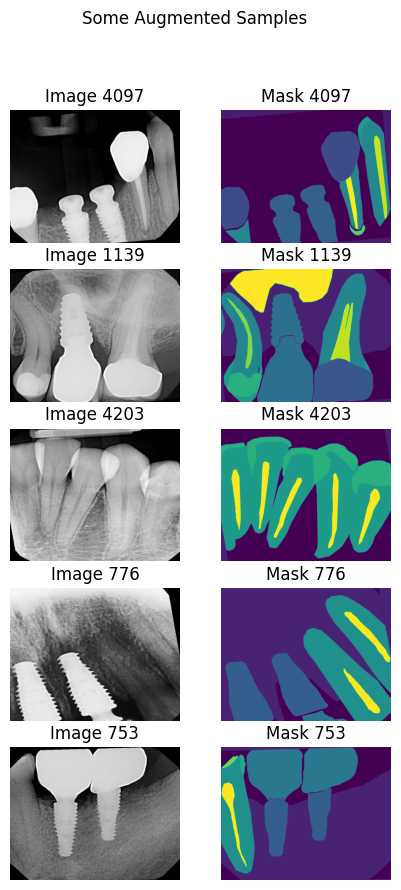

In [35]:
rand_idx = np.random.choice(5000, 5, False)

fig, ax = plt.subplots(5, 2, figsize=(5, 10))
fig.suptitle("Some Augmented Samples")

for i, idx in enumerate(rand_idx):
    ax[i, 0].imshow(new_imgs[idx], cmap="gray")
    ax[i, 1].imshow(new_masks[idx])
    ax[i, 0].set_title(f"Image {idx}")
    ax[i, 1].set_title(f"Mask {idx}")
    for a in ax[i, :]:
        a.axis("off")

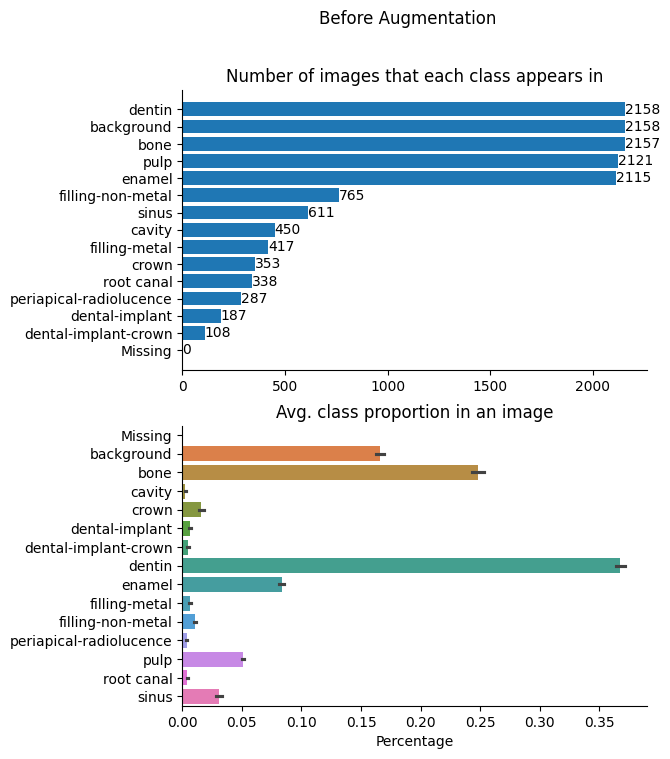

In [14]:
plot_label_dist(masks, classes, mapper, suptilte="Before Augmentation")

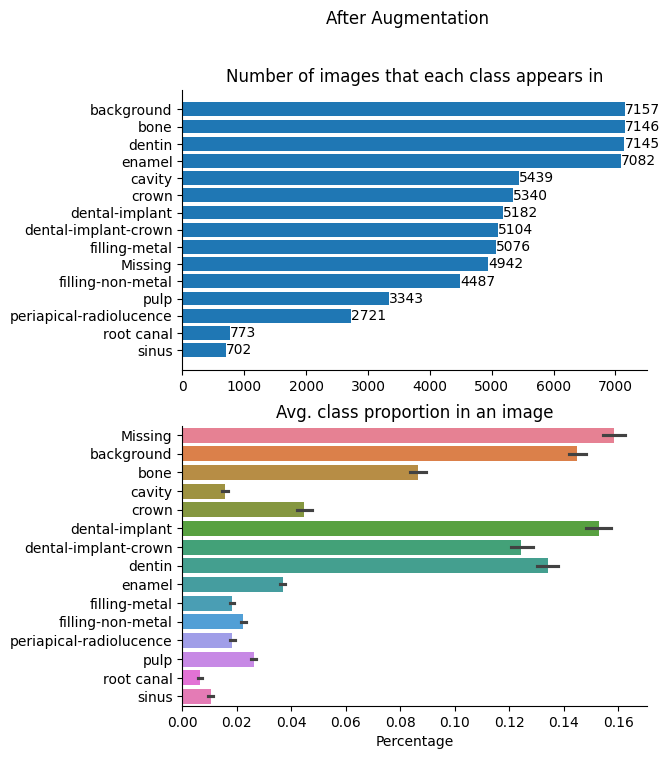

In [30]:
plot_label_dist(masks + new_masks, classes, mapper, suptilte="After Augmentation")

<BarContainer object of 14 artists>

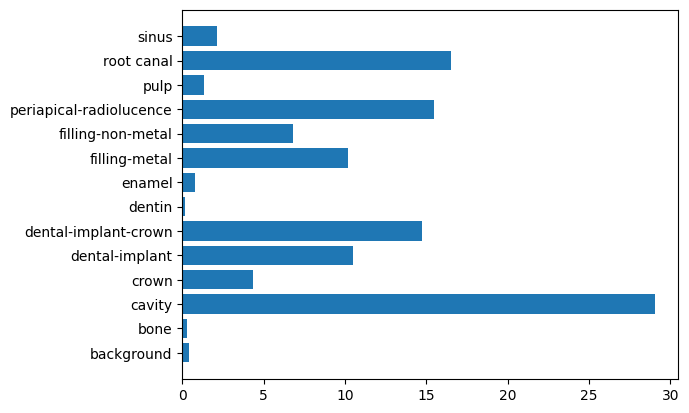

In [7]:
plt.barh(classes[1:], np.array([4.0475e-01, 2.6852e-01, 2.9043e+01, 4.3469e+00, 1.0520e+01,
        1.4762e+01, 1.8153e-01, 7.8775e-01, 1.0210e+01, 6.8107e+00, 1.5449e+01,
        1.3049e+00, 1.6534e+01, 2.1577e+00]))